# Autoregressive Integrated Moving Average with Explanatory Variable (ARIMAX)

The <a href="https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average">ARIMA</a> model is a generalisation of an ARMA model that can be applied to non-stationary time series.

The ARIMAX model is an extended version of ARIMA that includes independent predictor variables.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [2]:
matplotlib.rcParams['figure.figsize'] = (16, 9)
pd.options.display.max_columns = 999

## Load Dataset

In [3]:
df = pd.read_csv('../datasets/hourly-weather-wind_speed.csv', parse_dates=[0], index_col='DateTime')
print(df.shape)
df.head()

(5000, 36)


,ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,ts9,ts10,ts11,ts12,ts13,ts14,ts15,ts16,ts17,ts18,ts19,ts20,ts21,ts22,ts23,ts24,ts25,ts26,ts27,ts28,ts29,ts30,ts31,ts32,ts33,ts34,ts35,ts36
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-25 01:00:00,3.0,4.0,2.0,4.0,7.0,4.0,6.0,2.0,8.0,3.0,3.0,4.0,4.0,3.0,4.0,4.0,7.0,4.0,5.0,4.0,6.0,3.0,3.0,7.0,4.0,5.0,1.0,3.0,2.0,7.0,1.0,0.0,3.0,4.0,4.0,0.0
2017-03-25 02:00:00,3.0,4.0,3.0,5.0,6.0,1.0,7.0,2.0,5.0,1.0,2.0,4.0,5.0,4.0,4.0,4.0,8.0,3.0,3.0,1.0,3.0,3.0,2.0,6.0,4.0,6.0,2.0,3.0,2.0,6.0,1.0,0.0,5.0,4.0,4.0,0.0
2017-03-25 03:00:00,2.0,3.0,3.0,3.0,5.0,1.0,7.0,3.0,6.0,0.0,2.0,2.0,5.0,2.0,4.0,4.0,2.0,4.0,4.0,1.0,4.0,3.0,2.0,5.0,3.0,3.0,2.0,3.0,1.0,5.0,1.0,1.0,3.0,4.0,4.0,1.0
2017-03-25 04:00:00,2.0,3.0,3.0,4.0,2.0,4.0,3.0,1.0,1.0,0.0,2.0,3.0,10.0,2.0,4.0,5.0,5.0,3.0,4.0,2.0,4.0,2.0,2.0,5.0,4.0,3.0,2.0,2.0,1.0,5.0,1.0,1.0,6.0,0.0,0.0,1.0
2017-03-25 05:00:00,2.0,2.0,3.0,4.0,5.0,2.0,2.0,1.0,4.0,1.0,2.0,6.0,2.0,3.0,2.0,4.0,7.0,2.0,3.0,2.0,3.0,3.0,2.0,6.0,3.0,2.0,2.0,4.0,1.0,6.0,1.0,1.0,4.0,3.0,3.0,1.0


## Define Parameters

Make predictions for 24-hour period using a training period of four weeks.

In [4]:
dataset_name = 'Hourly Weather Wind Speed'
dataset_abbr = 'HWS'
model_name = 'ARIMAX'
context_length = 24*7*4 # Four weeks
prediction_length = 24

## Define Error Metric

The seasonal variant of the mean absolute scaled error (MASE) will be used to evaluate the forecasts.

In [5]:
def calc_sMASE(training_series, testing_series, prediction_series, seasonality=prediction_length):
    a = training_series.iloc[seasonality:].values
    b = training_series.iloc[:-seasonality].values
    d = np.sum(np.abs(a-b)) / len(a)
    errors = np.abs(testing_series - prediction_series)
    return np.mean(errors) / d

## Example ARIMAX Model

Exploration of how ARIMAX models work using a single example time series.

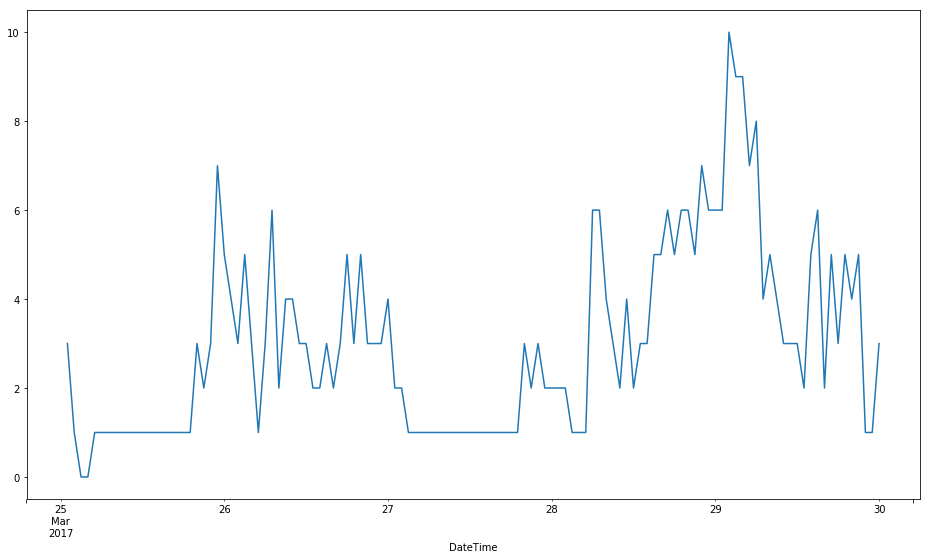

In [6]:
ts_ex = 'ts10'
df_ex = df.loc[:, ts_ex]

# Plot data from first five days
df_ex.iloc[:24*5].plot();

### Time Series Decomposition

Decompose the example time series into trend, seasonal, and residual components.

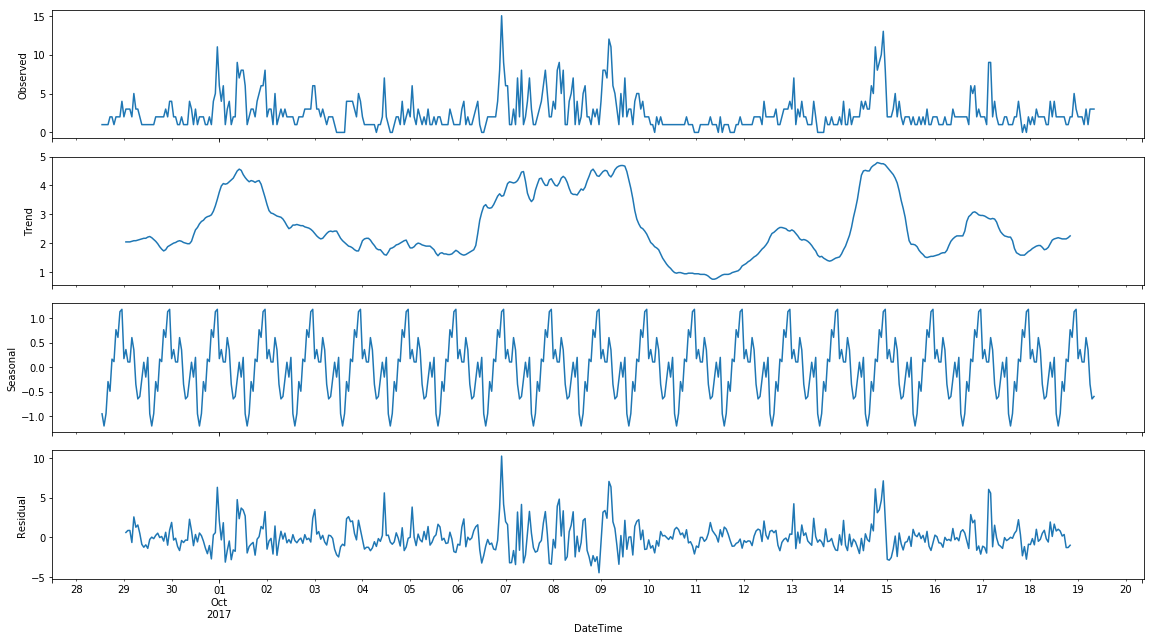

In [7]:
fig = seasonal_decompose(df_ex.iloc[-500:], model='additive').plot()

There doesn't appear to be a consistent trend. A Dicky-Fuller test can be used to confirm the stationarity.

In [8]:
dftest = adfuller(df_ex.iloc[-500:], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                -6.938823e+00
p-value                        1.037757e-09
#Lags Used                     4.000000e+00
Number of Observations Used    4.950000e+02
Critical Value (10%)          -2.569889e+00
Critical Value (1%)           -3.443630e+00
Critical Value (5%)           -2.867397e+00
dtype: float64

The very low p-value confirms that the data is stationary. There is daily seasonality, which will be captured as exogenous variables in our ARIMAX model. As there is no trend and seasonality is not being considered directly, no differencing will be applied to the time series.

### Plot ACF and PACF

The <a href="https://en.wikipedia.org/wiki/Autocorrelation">Autocorrelation Function</a> (ACF) is the correlation of a signal with a delayed copy of itself as a function of delay.

The <a href="https://en.wikipedia.org/wiki/Partial_autocorrelation_function">Partial Autocorrelation Function</a> (PACF) is the partial correlation of a signal with a delayed copy of itself, controlling for the values of the time series at all shorter delays, as a function of delay.

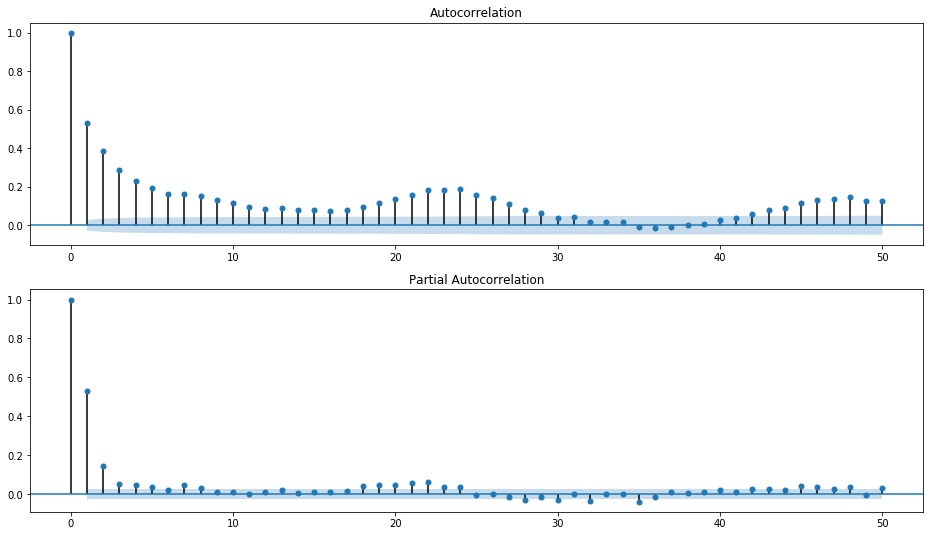

In [9]:
fig, ax = plt.subplots(2)
ax[0] = sm.graphics.tsa.plot_acf(df_ex, lags=50, ax=ax[0])
ax[1] = sm.graphics.tsa.plot_pacf(df_ex, lags=50, ax=ax[1])

There is clearly daily seasonality.

### Prepare Data

In [10]:
df_ex = pd.DataFrame(df_ex)
days = df_ex.index.dayofweek
dummy_days = pd.get_dummies(days)
dummy_days.columns = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
dummy_days.index = df_ex.index

df_ex = pd.concat([df_ex, dummy_days], axis=1)
df_ex.head()

,ts10,mon,tue,wed,thu,fri,sat,sun
DateTime,,,,,,,,
2017-03-25 01:00:00,3.0,0,0,0,0,0,1,0
2017-03-25 02:00:00,1.0,0,0,0,0,0,1,0
2017-03-25 03:00:00,0.0,0,0,0,0,0,1,0
2017-03-25 04:00:00,0.0,0,0,0,0,0,1,0
2017-03-25 05:00:00,1.0,0,0,0,0,0,1,0


### Build Model

Grid search will be implemented to identify optimal parameters for the ARIMAX(p, d, q) model, using the following possible values:

In [11]:
from itertools import product

ps = range(0, 5) # Up to 4 AR terms
ds = range(0, 2) # Either no or first differencing
qs = range(0, 5) # Up to 4 MA terms

params = product(ps, ds, qs)
params_list = list(params)
print("Number of parameter combinations for grid search: {}".format(len(params_list)))

Number of parameter combinations for grid search: 50


In [12]:
def optimiseARIMAX(time_series, params_list=params_list, test_length=prediction_length, train_length=context_length):
    ts = time_series.iloc[-(test_length+train_length):]
    ts_train = ts.iloc[:-test_length]
    ts_test = ts.iloc[-test_length:]
    
    # Select the best model using a holdout validation period
    val_length = test_length
    ts_train_val = ts.iloc[:-(test_length+val_length)]
    ts_val = ts.iloc[-(test_length+val_length):-test_length]
    
    results = []
    
    for params in params_list:
        p = params[0]
        d = params[1]
        q = params[2]
        
        # try/except loop in case model fails to converge for given parameters
        # Use SARIMAX model but disregard the seasonal parameters
        try:
            arimax = sm.tsa.SARIMAX(endog=ts_train_val.iloc[:, 0],
                                    exog=ts_train_val.iloc[:, 1:],
                                    order=(p, d, q)).fit()
        except:
            continue
        
        # Make predictions for validation holdout set and update best model if necessary
        val_pred = arimax.predict(start=ts_val.index[0],
                                  end=ts_val.index[-1],
                                  exog=ts_val.iloc[:, 1:],
                                  dynamic=True)
        sMASE = calc_sMASE(ts_train.iloc[:, 0], ts_val.iloc[:, 0], val_pred)

        results.append([params, sMASE])
            
    df_results = pd.DataFrame(results)
    df_results.columns = ['parameters', 'sMASE']
    df_results = df_results.sort_values(by='sMASE', ascending=True).reset_index(drop=True)
    
    # Retrain model with best parameters using all training data and generate test forecast
    # Use loop to fall back to next best model in case training fails using full dataset
    trained = False
    model_rank = 1
    while not trained:
        train_params = df_results.iloc[model_rank-1, 0]
        try:
            arimax = sm.tsa.SARIMAX(endog=ts_train.iloc[:, 0],
                                    exog=ts_train.iloc[:, 1:],
                                    order=train_params).fit()
            trained = True
        except:
            model_rank += 1
        
    summary = arimax.summary()
    
    # Start index must be greater than q. Fill missing initial entries with zeroes
    fcst = arimax.predict(start=ts_train.index[train_params[2]+1],
                          end=ts_test.index[-1],
                          exog=ts_test.iloc[:, 1:])
    fcst = np.concatenate([np.array([0 for i in range(train_params[2]+1)]), fcst])
    fcst = pd.DataFrame(data=fcst, index=ts.index, columns=['pred%s' % ts.columns[0][2:]])
    
    return fcst, train_params, summary

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
%%time
fcst, train_params, summary = optimiseARIMAX(df_ex)
df_ex = pd.concat([df_ex, fcst], axis=1)
print("Best model: ARIMAX{}".format(train_params))
print(summary)

Best model: ARIMAX(0, 1, 0)
                           Statespace Model Results                           
Dep. Variable:                   ts10   No. Observations:                  672
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1389.682
Date:                Sat, 13 Oct 2018   AIC                           2795.364
Time:                        19:30:24   BIC                           2831.434
Sample:                    09-20-2017   HQIC                          2809.334
                         - 10-18-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
mon           -1.2543      0.700     -1.792      0.073      -2.626       0.118
tue           -0.1472      1.000     -0.147      0.883      -2.108       1.813
wed            0.2099   

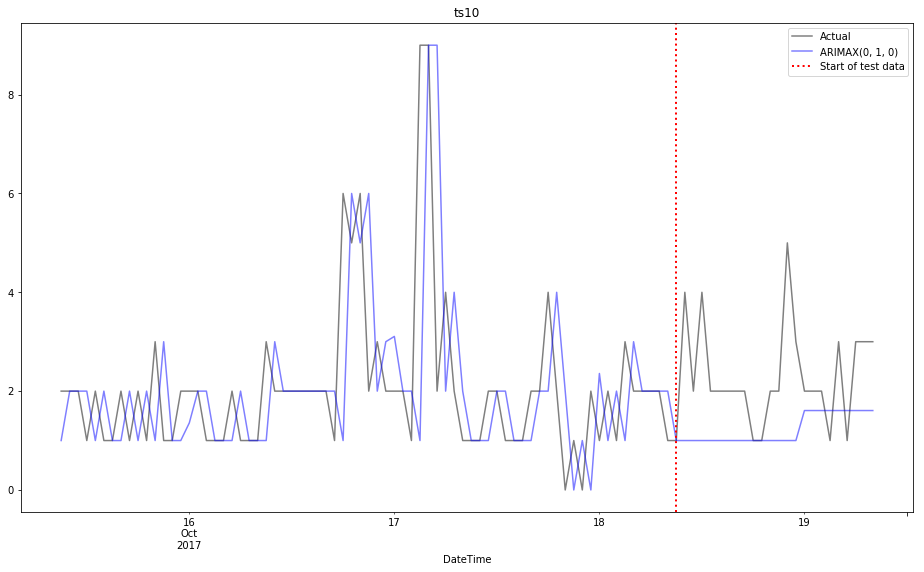

In [15]:
# Example forecast
fcst0 = df_ex.copy()
fcst0['pred%s' % ts_ex[2:]][fcst0['pred%s' % ts_ex[2:]] < 0] = 0

fcst0.iloc[-4*prediction_length:, 0].plot(label='Actual', c='k', alpha=0.5)
fcst0.iloc[-4*prediction_length:, -1].plot(label='ARIMAX%s' % str(train_params), c='b', alpha=0.5)
plt.axvline(x=fcst0.index[-prediction_length], linestyle=':', linewidth=2, color='r', label='Start of test data')
plt.legend()
plt.title(ts_ex);

## Evaluating ARIMAX

To evaluate ARIMAX, forecasts will be generated for each time series using the grid search methodology shown above (with subsequent zeroing of the negative values). sMASE will be calculated for each individual time series, and the mean of all these scores will be used as the overall accuracy metric for ARIMAX on this dataset.

In [16]:
parameters = []
results = df.iloc[-(prediction_length+context_length):].copy()

tic = time()
for i, col in enumerate(df.columns):
    if i % 10 == 0:
        toc = time()
        print("Running predictions for {}. Cumulative time: {:.1f} minutes.".format(col, (toc-tic)/60))
        
    # Prepare DataFrame for selected column
    dft = df.loc[:, col]
    dft = pd.DataFrame(dft)
    days = dft.index.dayofweek
    dummy_days = pd.get_dummies(days)
    dummy_days.columns = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
    dummy_days.index = dft.index
    dft = pd.concat([dft, dummy_days], axis=1)
    
    # Find best model
    fcst, train_params, summary = optimiseARIMAX(dft)
    # Add predictions to results DataFrame
    results['pred%s' % col[2:]] = fcst.values
    # Store model parameteres for reference
    parameters.append(train_params)

toc = time()
print("Finished! Total run time: {:.1f} minutes.".format((toc-tic)/60))

Running predictions for ts1. Cumulative time: 0.0 minutes.
Running predictions for ts11. Cumulative time: 8.3 minutes.
Running predictions for ts21. Cumulative time: 20.1 minutes.
Running predictions for ts31. Cumulative time: 30.9 minutes.
Finished! Total run time: 35.1 minutes.


Predictions must be greater than 0 and the actual values are always integers.

In [17]:
results0 = results.copy()
results0[results0 < 0] = 0
results0 = results0.apply(round)
results0.tail()

,ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,ts9,ts10,ts11,ts12,ts13,ts14,ts15,ts16,ts17,ts18,ts19,ts20,ts21,ts22,ts23,ts24,ts25,ts26,ts27,ts28,ts29,ts30,ts31,ts32,ts33,ts34,ts35,ts36,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9,pred10,pred11,pred12,pred13,pred14,pred15,pred16,pred17,pred18,pred19,pred20,pred21,pred22,pred23,pred24,pred25,pred26,pred27,pred28,pred29,pred30,pred31,pred32,pred33,pred34,pred35,pred36
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-10-19 04:00:00,7.0,5.0,2.0,7.0,0.0,1.0,1.0,2.0,4.0,3.0,3.0,4.0,2.0,4.0,2.0,2.0,2.0,2.0,3.0,1.0,3.0,3.0,1.0,3.0,3.0,4.0,3.0,2.0,1.0,3.0,1.0,1.0,3.0,5.0,5.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,3.0,2.0,1.0,2.0,1.0,3.0,2.0,7.0,3.0,3.0,3.0,1.0,2.0,2.0,3.0,6.0,2.0,3.0,3.0,4.0,4.0,2.0,5.0,4.0,1.0,1.0,6.0,3.0,3.0,1.0
2017-10-19 05:00:00,2.0,5.0,2.0,4.0,0.0,1.0,1.0,2.0,3.0,1.0,3.0,5.0,4.0,5.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,3.0,4.0,3.0,3.0,2.0,3.0,1.0,0.0,5.0,5.0,5.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,3.0,2.0,1.0,2.0,1.0,3.0,2.0,7.0,3.0,3.0,3.0,1.0,2.0,2.0,3.0,6.0,2.0,3.0,3.0,4.0,4.0,2.0,5.0,4.0,2.0,1.0,6.0,3.0,3.0,1.0
2017-10-19 06:00:00,3.0,7.0,2.0,5.0,0.0,1.0,2.0,1.0,3.0,3.0,3.0,5.0,4.0,3.0,2.0,4.0,2.0,2.0,2.0,1.0,4.0,8.0,2.0,2.0,3.0,2.0,3.0,2.0,5.0,1.0,1.0,0.0,3.0,4.0,4.0,0.0,2.0,1.0,2.0,2.0,1.0,2.0,3.0,2.0,1.0,2.0,1.0,3.0,2.0,7.0,3.0,3.0,3.0,1.0,2.0,2.0,3.0,6.0,2.0,3.0,3.0,4.0,4.0,2.0,5.0,4.0,2.0,2.0,6.0,3.0,3.0,2.0
2017-10-19 07:00:00,5.0,5.0,2.0,2.0,2.0,1.0,1.0,2.0,3.0,3.0,1.0,5.0,3.0,1.0,3.0,2.0,2.0,2.0,4.0,2.0,5.0,3.0,2.0,3.0,3.0,3.0,2.0,2.0,5.0,3.0,1.0,1.0,3.0,5.0,5.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,3.0,2.0,1.0,2.0,1.0,3.0,2.0,7.0,3.0,3.0,3.0,1.0,2.0,2.0,3.0,6.0,2.0,3.0,3.0,4.0,4.0,2.0,5.0,4.0,2.0,2.0,6.0,3.0,3.0,2.0
2017-10-19 08:00:00,1.0,7.0,3.0,3.0,0.0,1.0,1.0,2.0,4.0,3.0,1.0,4.0,2.0,3.0,2.0,2.0,1.0,1.0,2.0,1.0,4.0,4.0,0.0,1.0,3.0,4.0,2.0,2.0,6.0,3.0,1.0,1.0,1.0,4.0,4.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,3.0,2.0,1.0,2.0,1.0,3.0,2.0,7.0,3.0,3.0,3.0,1.0,2.0,2.0,3.0,6.0,2.0,3.0,3.0,4.0,4.0,2.0,5.0,4.0,2.0,3.0,6.0,3.0,3.0,3.0


In [18]:
sMASEs = []
for i, col in enumerate(df.columns):
    sMASEs.append(calc_sMASE(results0[col].iloc[-(context_length + prediction_length):-prediction_length],
                             results0[col].iloc[-prediction_length:],
                             results0['pred%s' % str(i+1)].iloc[-prediction_length:]))

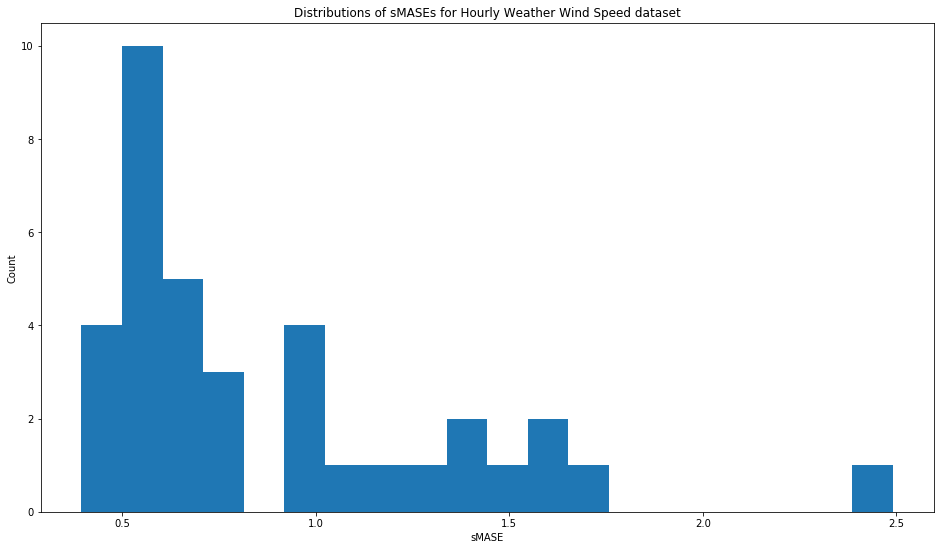

In [19]:
fig, ax = plt.subplots()
ax.hist(sMASEs, bins=20)
ax.set_title('Distributions of sMASEs for {} dataset'.format(dataset_name))
ax.set_xlabel('sMASE')
ax.set_ylabel('Count');

In [20]:
sMASE = np.mean(sMASEs)
print("Overall sMASE: {:.4f}".format(sMASE))

Overall sMASE: 0.8891


Show some example forecasts.

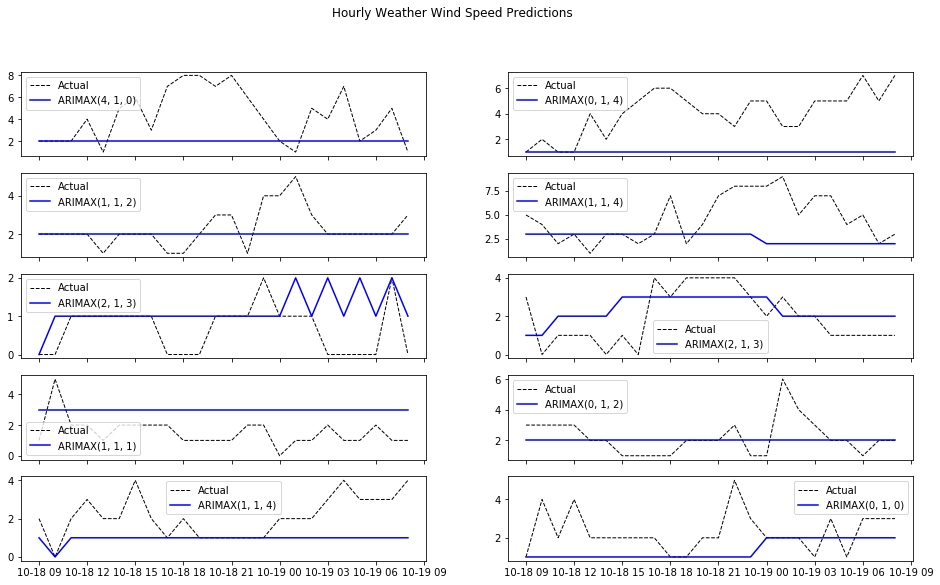

In [21]:
fig, ax = plt.subplots(5, 2, sharex=True)
ax = ax.ravel()

for col in range(1, 11):
    ax[col-1].plot(results0.index[-prediction_length:], results0['ts%s' % col].iloc[-prediction_length:],
                   label='Actual', c='k', linestyle='--', linewidth=1)
    ax[col-1].plot(results0.index[-prediction_length:], results0['pred%s' % col].iloc[-prediction_length:],
                   label='ARIMAX%s' % str(parameters[col-1]), c='b')
    ax[col-1].legend()
fig.suptitle('{} Predictions'.format(dataset_name));

Clearly, many of the time series adopt an ARIMAX models that just flatline at zero for the test period. The higher order models appear to do a better job of generating forecasts, although when such a large number of data points are zero, always forecasting zero is presumably a strategy that performs quite well.

Store the predictions and accuracy score for the ARIMAX models.

In [22]:
import pickle
    
with open('{}-sMASE.pkl'.format(dataset_abbr), 'wb') as f:
    pickle.dump(sMASE, f)
    
with open('../_results/{}/{}-results.pkl'.format(model_name, dataset_abbr), 'wb') as f:
    pickle.dump(results.iloc[-prediction_length:], f)